## Super resolution

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [0]:
il = ImageList.from_folder(path_hr)

In [0]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [5]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 96 into /root/.fastai/data/oxford-iiit-pet/small-96


resizing to 256 into /root/.fastai/data/oxford-iiit-pet/small-256


In [0]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data = get_data(bs,size)

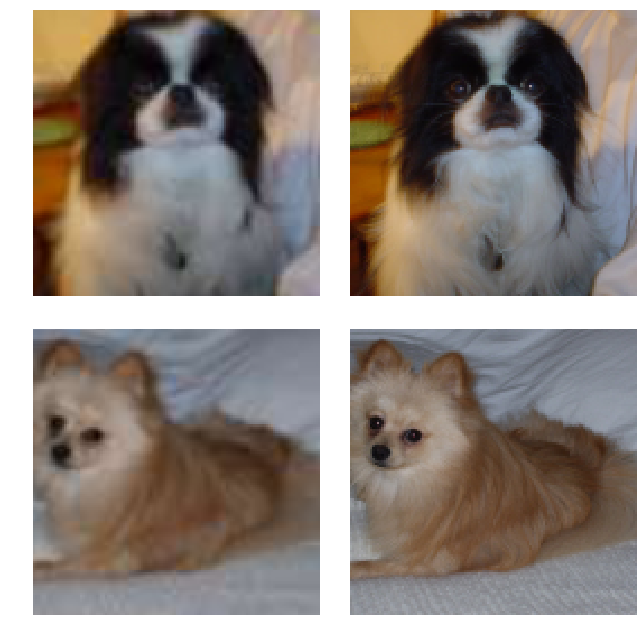

In [9]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [12]:
gram_matrix(t)

tensor([[[0.0846, 0.0747, 0.0638],
         [0.0747, 0.0679, 0.0602],
         [0.0638, 0.0602, 0.0570]],

        [[0.0846, 0.0747, 0.0638],
         [0.0747, 0.0679, 0.0602],
         [0.0638, 0.0602, 0.0570]]])

We use L1 as the loss function:

In [0]:
base_loss = F.l1_loss

The `features` attribute on VGG contains the convolutional part of the model (we don't need the rest). The `eval` mode is because we're not training it, and the False in `requires_grad()` is because we won't update weights of this model. Only used for loss inference!

In [14]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:22<00:00, 24393400.01it/s]


We get the blocks previous to features map size changes:

In [15]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [18]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 105011846.93it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


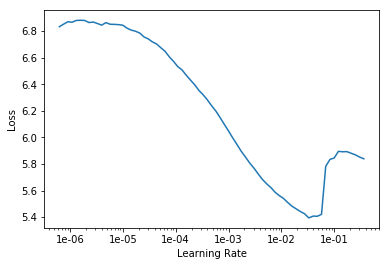

In [19]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.890404,3.702256,0.138537,0.227842,0.314969,0.220965,0.554574,1.212725,1.032644,04:14
1,3.740672,3.575242,0.138948,0.226158,0.307844,0.213266,0.526552,1.165650,0.996824,04:08
2,3.689235,3.511857,0.141369,0.222067,0.300620,0.208088,0.523381,1.140835,0.975497,04:07
3,3.644418,3.489892,0.151021,0.225353,0.301476,0.205293,0.504210,1.144028,0.958511,04:07
4,3.569974,3.390136,0.140018,0.220618,0.293421,0.199753,0.498589,1.102100,0.935638,04:06
5,3.526404,3.373616,0.137373,0.220725,0.293752,0.199176,0.490361,1.104695,0.927533,04:06
6,3.493304,3.303378,0.136511,0.219611,0.290362,0.196481,0.466694,1.073847,0.919873,04:05
7,3.486942,3.295532,0.136752,0.218013,0.287870,0.195487,0.466757,1.069608,0.921045,04:05
8,3.442801,3.248266,0.133868,0.217217,0.284314,0.192642,0.458157,1.057151,0.904916,04:07
9,3.332444,3.141304,0.130360,0.214100,0.278656,0.185627,0.434290,1.029092,0.869180,04:07


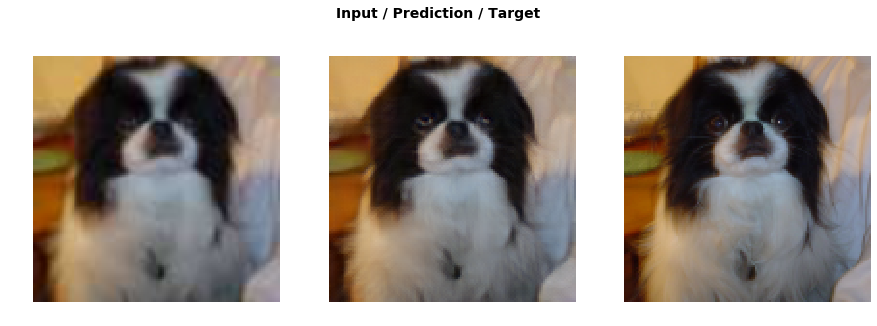

In [22]:
do_fit('1a', slice(lr*10))

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.314471,3.129911,0.130554,0.214129,0.278330,0.185224,0.429096,1.024848,0.867731,04:17
1,3.331087,3.125582,0.130575,0.213925,0.277943,0.184955,0.428522,1.023207,0.866453,04:17
2,3.305549,3.120920,0.130454,0.213683,0.277553,0.184488,0.428811,1.021545,0.864386,04:17
3,3.297675,3.113644,0.130183,0.213172,0.276985,0.184171,0.426532,1.019462,0.863140,04:17
4,3.304247,3.107551,0.131015,0.213124,0.276674,0.183937,0.423598,1.017011,0.862192,04:17
5,3.303902,3.106754,0.130525,0.213045,0.276363,0.183386,0.426375,1.017712,0.859347,04:17
6,3.294612,3.109451,0.130966,0.213065,0.276316,0.183948,0.424765,1.017141,0.863249,04:17
7,3.288731,3.103862,0.130290,0.212305,0.275408,0.183719,0.425340,1.014359,0.862442,04:17
8,3.291211,3.095773,0.131269,0.212856,0.275212,0.183700,0.419119,1.010537,0.863080,04:17
9,3.250440,3.080037,0.129904,0.211809,0.274042,0.182310,0.418685,1.007775,0.855511,04:17


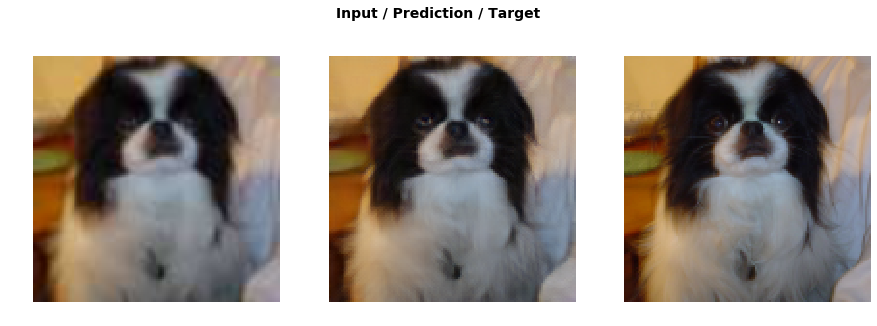

In [24]:
do_fit('1b', slice(1e-5,lr))

In [0]:
data = get_data(12,size*2)

In [26]:
learn.data = data
learn.freeze()
gc.collect()

19152

In [27]:
learn.load('1b');

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
do_fit('2a')

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.245597,2.192999,0.156781,0.257295,0.295441,0.154400,0.379834,0.585548,0.363700,17:41
1,2.223174,2.160663,0.157915,0.258628,0.294574,0.154026,0.361624,0.574393,0.359503,17:17
2,2.187052,2.143338,0.157653,0.258123,0.293040,0.152298,0.357431,0.569320,0.355473,17:18


In [0]:
learn.unfreeze()

In [0]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [0]:
learn = None
gc.collect();

In [0]:
256/320*1024

In [0]:
256/320*1600

In [0]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [0]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [0]:
learn.load('2b');

In [0]:
learn.data = data_mr

In [0]:
fn = data_mr.valid_ds.x.items[0]; fn

In [0]:
img = open_image(fn); img.shape

In [0]:
p,img_hr,b = learn.predict(img)

In [0]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [0]:
Image(img_hr).show(figsize=(18,15))